In [10]:
import numpy as np 
import pandas as pd 
from sklearn.svm import SVR
from sklearn.ensemble import HistGradientBoostingRegressor, RandomForestRegressor, ExtraTreesRegressor, GradientBoostingRegressor
from sklearn.metrics import *
from sklearn.model_selection import train_test_split, KFold, cross_val_score

In [11]:
df2 = pd.read_excel(r"C:\Users\madam\Desktop\2805 RF Dataset.xlsx")
df2.head(5)

,SB,HB,BD,TB,Pf(kg/m3),XB(m),E(GPa),X50(m)
0,1.198974,1.366301,27.254728,0.736923,0.495592,0.576549,59.946268,0.341959
1,1.145491,1.303856,27.294058,0.762451,0.455873,0.612741,60.002893,0.386073
2,1.242155,1.317184,27.248093,0.896496,0.501227,0.994937,60.042361,0.358173
3,1.277583,1.316653,27.302029,0.727691,0.439071,1.093234,60.066082,0.453862
4,1.283793,1.359817,27.324111,0.812233,0.494853,1.122299,59.986148,0.525007


In [12]:
X = df2.drop(columns=['X50(m)'])
y = df2['X50(m)']
X.shape, y.shape

((2805, 7), (2805,))

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape

((2103, 7), (702, 7))

In [14]:
from mealpy import FloatVar, StringVar, IntegerVar, BoolVar, MixedSetVar, PSO, GWO, GOA, Problem
from mealpy.utils.visualize import *
from mealpy.utils import io

In [15]:
def objective_function(params):
    params = params.reshape(-1)
    params_dict = {
        'criterion': 'poisson',
        'n_estimators': int(params[0]),
        'max_depth': int(params[1]),
        'min_impurity_decrease': params[2],
    }
    rf_model = RandomForestRegressor(**params_dict, random_state=42)
    #cv = KFold(n_splits=5)
    #cv_score  = cross_val_score(hgb, X_train, y_train, cv=cv, scoring='r2')
    rf_model.fit(X_train, y_train)
    y_pred =  rf_model.predict(X_test)
    
    return r2_score(y_test, y_pred)

In [16]:
bounds = [(10, 2000), # Lower and upper bounds for n_estimators (0)
          (2, 30), # Lower and upper bounds for max_depth (1)
          (0.0001, 1.0),  # Lower and upper bounds for min_impurity_decrease (2)
         ]

# Define the problem dictionary for the optimizer
problem_dict = {
    "bounds": FloatVar(lb=np.array([bound[0] for bound in bounds]), ub=np.array([bound[1] for bound in bounds]), name="delta"),
    "obj_func": objective_function,
    "minmax": "max", # Minimize fitness (negative F1_Score)
}

In [17]:
model = GWO.OriginalGWO(epoch=100, pop_size=80)
g_best = model.solve(problem_dict)

2024/10/10 02:00:04 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: Solving single objective optimization problem.
2024/10/10 02:05:42 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 1, Current best: 0.8333776754622562, Global best: 0.8333776754622562, Runtime: 128.65678 seconds
2024/10/10 02:07:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 2, Current best: 0.8333776754622562, Global best: 0.8333776754622562, Runtime: 135.47452 seconds
2024/10/10 02:09:57 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 3, Current best: 0.8336296442277418, Global best: 0.8336296442277418, Runtime: 119.65707 seconds
2024/10/10 02:11:15 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 4, Current best: 0.8337803491414958, Global best: 0.8337803491414958, Runtime: 78.19956 seconds
2024/10/10 02:12:03 PM, INFO, mealpy.swarm_based.GWO.OriginalGWO: >>>Problem: P, Epoch: 5, Current best: 0.8337803491414958, Global best: 0.83378034

In [18]:
print(f"Solution: {g_best.solution}, Fitness: {g_best.target.fitness}")

Solution: [4.74734531e+01 2.07280051e+01 1.00000000e-04], Fitness: 0.8337974764804166


In [21]:
best_n_estimators = int(g_best.solution[0])
best_max_depth = int(g_best.solution[1])
best_min_impurity_decrease = g_best.solution[2]

print(f"best_n_estimators = {best_n_estimators}")
print(f"best_max_depth = {best_max_depth}")
print(f"best_min_impurity_decrease = {best_min_impurity_decrease}")


best_n_estimators = 47
best_max_depth = 20
best_min_impurity_decrease = 0.0001


In [24]:
best_params = {
    'criterion': 'poisson',
    'n_estimators': int(model.g_best.solution[0]),
    'max_depth': int(model.g_best.solution[1]),
    'min_impurity_decrease': model.g_best.solution[2],
 
}

best_rf = RandomForestRegressor(**best_params, random_state=42)
cv = KFold(n_splits=5, shuffle=True)
score = cross_val_score(best_rf, X_train, y_train, cv=cv, n_jobs=-1, scoring='r2')
best_rf.fit(X_train, y_train)

RandomForestRegressor(criterion='poisson', max_depth=20,
                      min_impurity_decrease=np.float64(0.0001), n_estimators=47,
                      random_state=42)

In [25]:
y_pred = best_rf.predict(X_test)

In [26]:
print('RMSE:',mean_squared_error(y_test, y_pred, squared=False))
print('MSE:',mean_squared_error(y_test, y_pred))
print('R2:', r2_score(y_test, y_pred))
print('MAE:',mean_absolute_error(y_test, y_pred))
print('MAPE:',mean_absolute_percentage_error(y_test, y_pred))
print('Explained Variance Score:',explained_variance_score(y_test, y_pred))

RMSE: 0.06398017699233943
MSE: 0.00409346304797108
R2: 0.8337974764804166
MAE: 0.04815156632055114
MAPE: 0.23811720910665482
Explained Variance Score: 0.8342603618749638


d:\projects\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [27]:
y_pred2 = best_rf.predict(X_train)

In [28]:
print('RMSE:',mean_squared_error(y_train, y_pred2, squared=False))
print('MSE:',mean_squared_error(y_train, y_pred2))
print('R2:', r2_score(y_train, y_pred2))
print('MAE:',mean_absolute_error(y_train, y_pred2))
print('MAPE:',mean_absolute_percentage_error(y_train, y_pred2))
print('Explained Variance Score:',explained_variance_score(y_train, y_pred2))

RMSE: 0.06458034559465581
MSE: 0.004170621037125179
R2: 0.8470349411351056
MAE: 0.04995843621908135
MAPE: 0.2508967274382231
Explained Variance Score: 0.8470460356972682


d:\projects\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [29]:
import shap

shap.initjs()

d:\projects\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


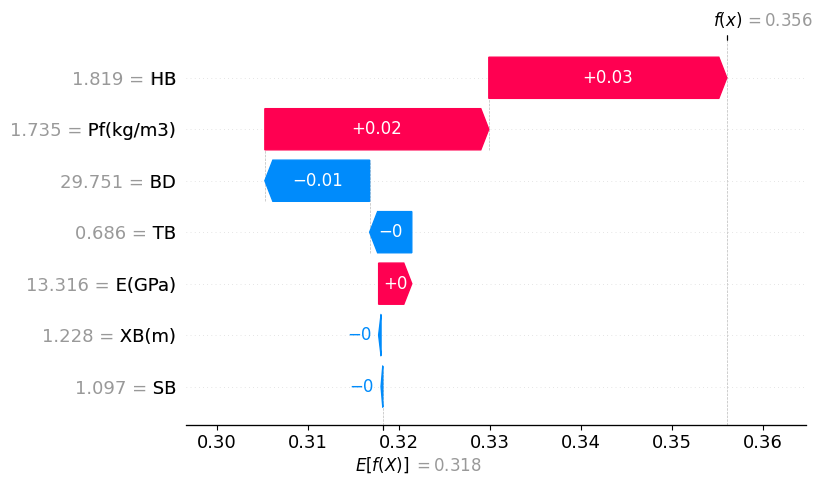

In [30]:
explainer = shap.Explainer(best_rf)
shap_values = explainer(X_test)

shap.waterfall_plot(shap_values[0])

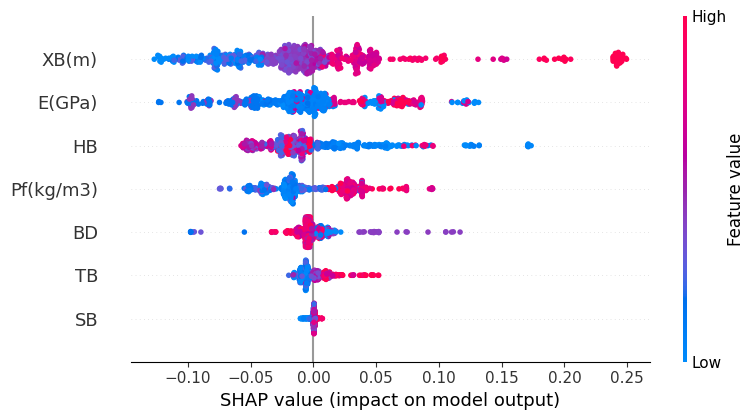

In [31]:
shap.summary_plot(shap_values, X_test)

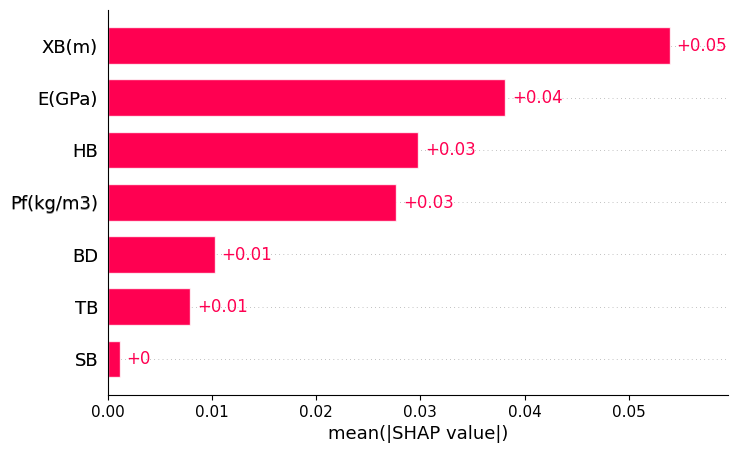

In [33]:
shap.plots.bar(shap_values)

In [34]:
import pickle
filename = 'RF-model.pkl'
pickle.dump(best_rf, open(filename, 'wb'))